# Data Science in Practice - Analysis - 3001

## Spotting Sandbags by Rate of Upsets.

Author : Eoghan Cunningham

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats
import re
from datetime import datetime
import papermill as pm 
%matplotlib inline

In [67]:
british_grades_dict = {'D': 0,'HD' : 0,'VD' : 0,'HVD' : 0,'MS' : 0, 
                       'S' : 1,'HS' : 2,'MVS' : 3,'VS' : 4,'HVS' : 5,
                       'E1' : 6,'E2' : 7,'E3' : 8,'E4' : 9,'E5' : 10,
                       'E6' : 11,'E7' : 12,'E8' : 13,'E9' : 14,'E10' : 14,
                       'E11' : 15, 'XS': 16, 'HXS' : 17}

In [84]:
ascents = pd.read_csv('../data/ascents_cleaned.csv').drop('Unnamed: 0', axis = 1)
ascents.sample(5)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset
45576,Silhouette,"?Jun, 1988",AltLd O/S,NaN,120564,E2,Cloggy,Pen Trwyn,E2,E4,0
49760,The Fang,"17 Oct, 2010",AltLd O/S,NaN,93568,HVS,Tremadog,Tremadog,VS,E3,0
40344,Covent Garden,"19 Aug, 2014",Lead O/S,NaN,132454,VS,Millstone Edge,Burbage South Valley Boulders,S,E4,0
36288,Edge Lane,"??, 2009",Lead O/S,NaN,26705,E5,Millstone Edge,Stanage Popular,E2,E6,0
13645,Park Lane/Doomsville,"9 Sep, 2018",AltLd O/S,Lead top pitch. Exposed and interesting climbi...,233494,E2,Gogarth North/Main,Cromlech boulders,MVS,E3,0


We hope to use the rate of upsets on a route to produce a list of sandbagged (poorly graded) routes. Let us first consider the routes with the highest rate of upsets.

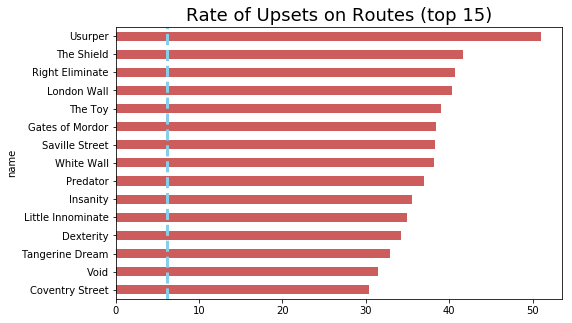

In [69]:
plt.figure(figsize = (8,5))
plt.title('Rate of Upsets on Routes (top 15)', fontsize=18)
(ascents.groupby('name')['upset'].mean()*100).sort_values()[-15:]\
.plot.barh(color = 'IndianRed', label = 'Rate of Upsets on Routes')\
.axvline(ascents.upset.mean()*100, color='skyblue', linestyle='--', linewidth=3)
plt.show()

Here we can see the 20 routes with the highest rate of upsets on them. Each of their rates is far above the mean. We are using a climbers max grade in our calculations of upsets. These max grades are calculated by year. To accurately assess the limitations of our max grade calculations we can consider the distribution of ascents throughout the year. 

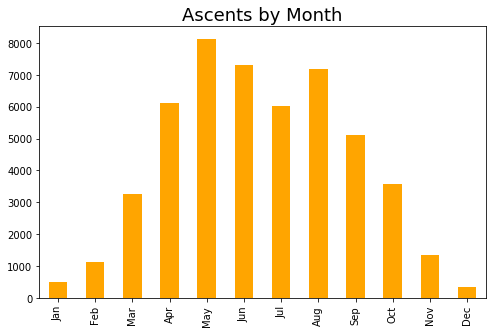

In [70]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize = (8,5))
plt.title('Ascents by Month', fontsize=18)
ascents[~ascents.date.str.contains('\?')].apply(lambda row: re.search(r'([A-Za-z])+', str(row.date))[0], axis = 1)\
.value_counts().reindex(months).plot.bar(color = 'orange')
plt.show()

We can infer from the above the plot the low probability that an ascent occurred as many 11 months before or after the ascent that gave the climber their max grade for the year. **fix this **

 

## Weighted Upsets

Currently we are only considering upsets in a binary fashion. We can also consider the size of each upset. For example an E5 climber falling off an E1 is far more significant than an E2 climber falling off the same route. 

We can define a new function to produce weighted upsets and then reconsider the worst offending routes. 

In [71]:
def weigh_upset(upset, route_grade, climber_grade) :
    if upset == 1:
        return 1 + british_grades_dict[climber_grade] - british_grades_dict[route_grade]
    else : return 0    

In [73]:
ascents['upset_weight'] = ascents.apply(lambda row: weigh_upset(\
                                                         row['upset'],
                                                         row['grade'],
                                                         row['max_grade'],
                                                        ), axis = 1)
ascents[ascents.upset == 1].sample(3)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,upset_weight
54677,The Brothers,"4 Oct, 2012",AltLd dog,NaN,159308,VS,Tremadog,Porthclais Area,S,E1,1,3
5978,Cenotaph Corner,"??, 1983",Lead dog,NaN,81184,E1,Dinas Cromlech,Stoney Middleton,E1,E4,1,4
39886,Embankment 4,"20 Jun, 2012",Lead dog,A silly fall near the top - not under pressure...,26551,E1,Millstone Edge,Stanage Popular,VS,E2,1,2


In [36]:
ascents.sample(10)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,upset_weight
42519,The Mall,"11 Aug, 2012",Lead O/S,NaN,123360,VS,Millstone Edge,Australia,VS,E3,0,0
967,Midnight Cruiser,"11 Mar, 2017",Lead rpt,NaN,149776,E1,Fair Head,Avon Gorge (Main Area),E1,E2,0,0
5179,Left Wall,"?Jun, 2005",Lead O/S,NaN,46709,E2,Dinas Cromlech,Birchen Edge,E1,E3,0,0
23658,Quickstep,"25 Apr, 2011",Lead rpt,NaN,50984,VS,Stennis Head,St. Govan's Head,VS,E3,0,0
16665,Bela Lugosi is Dead,"24 Apr, 2016",Lead O/S,NaN,127846,E1,Rainbow Slab Area,Avon Gorge (Sea Walls Area),HVS,E4,0,0
53418,Grim Wall,"29 Dec, 2008",AltLd O/S,NaN,35790,VS,Tremadog,Froggatt Edge,VS,E2,0,0
42919,Lambeth Chimney,"2 Apr, 2017",Lead rpt,"Well done to F, quite exposed especially if a ...",87803,HS,Millstone Edge,Stanage Popular,HVS,E5,0,0
47871,Christmas Curry,"5 Jun, 2010",Lead O/S,NaN,48434,S,Tremadog,Avon Gorge (Sea Walls Area),VS,E3,0,0
32758,Gimbals,"16 Jun, 2010",Lead dog,"Fell off the sandy crux, got it second go. Nice",63328,HVS,Millstone Edge,Stanage Popular,HVS,E3,1,4
14587,Psychotherapy,"14 Mar, 2012",Lead rpt,NaN,11116,E2,Vivian Quarry,Pen Trwyn,E3,E6,0,0


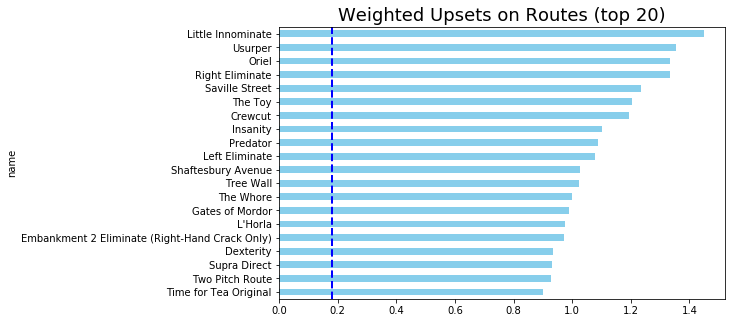

In [37]:
plt.figure(figsize = (8,5))
plt.title('Weighted Upsets on Routes (top 20)', fontsize=18)
ascents.groupby('name')['upset_weight'].mean().sort_values()[-20:]\
.plot.barh(color = 'SkyBlue', label = 'Rate of Upsets on Routes')\
.axvline(ascents.upset_weight.mean(), color='b', linestyle='--', linewidth=2)
plt.show()

## Comparing Ascents by Local and Visiting Climbers

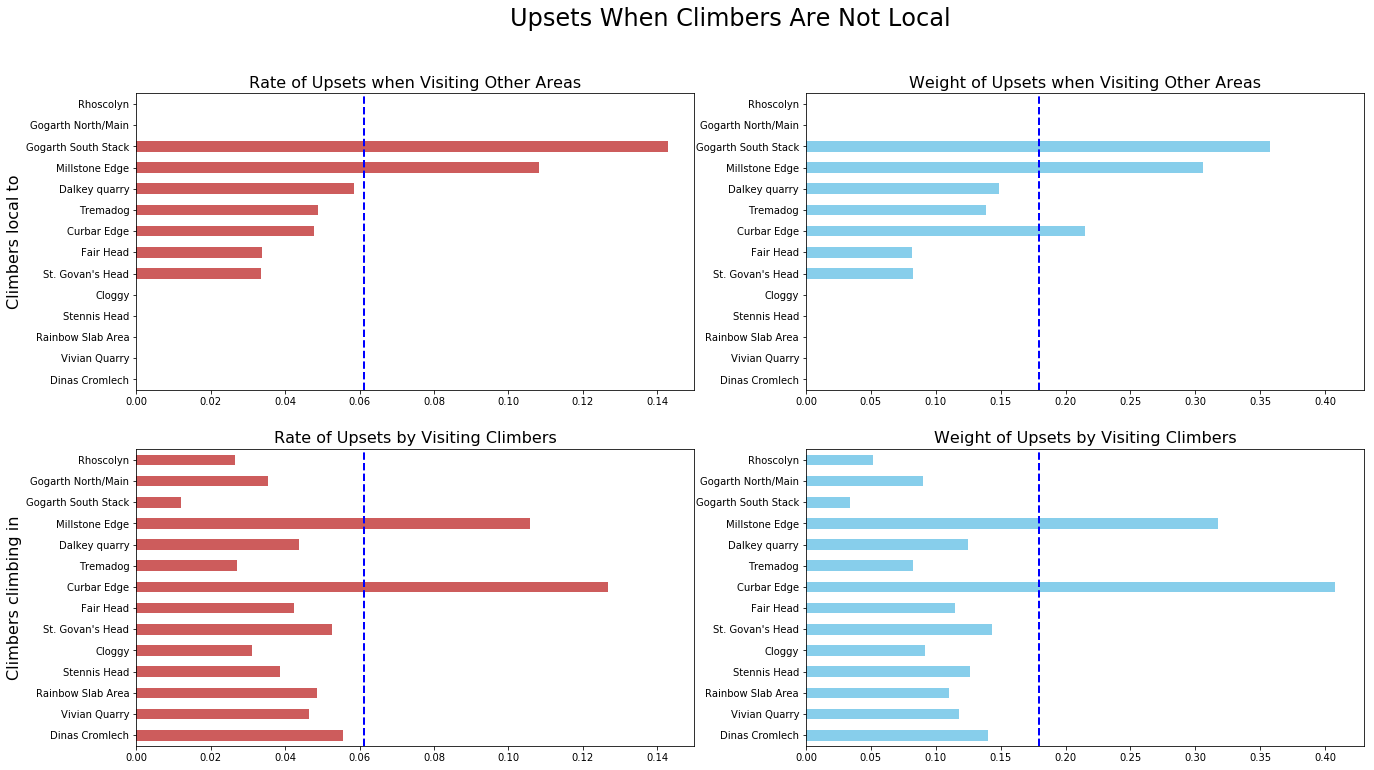

In [38]:
crags = ascents.location.unique()

f, axarr = plt.subplots(2, 2,figsize=(22, 12))

f.suptitle('Upsets When Climbers Are Not Local', fontsize=24)

popular_crags_by_upsets = ascents[ascents.location != ascents.local_to].groupby('local_to')['upset'].mean()\
.reindex(crags).sort_values()[-20:]

axarr[1,0].set_xlim([0, 0.15])
popular_crags_by_upsets\
.plot.barh(color = 'IndianRed', ax = axarr[0,0])\
.axvline(ascents.upset.mean(), color='b', linestyle='--', linewidth=2)

axarr[0,1].set_xlim([0, 0.43])
ascents[ascents.location != ascents.local_to].groupby('local_to')['upset_weight'].mean().reindex(popular_crags_by_upsets.index)\
.plot.barh(color = 'SkyBlue', ax = axarr[0,1])\
.axvline(ascents.upset_weight.mean(), color='b', linestyle='--', linewidth=2)

main_locations_by_upset = ascents[ascents.location != ascents.local_to].groupby('location')['upset_weight'].mean().sort_values()

axarr[1,0].set_xlim([0, 0.15])
ascents[ascents.location != ascents.local_to].groupby('location')['upset'].mean().reindex(popular_crags_by_upsets.index)\
.plot.barh(color = 'IndianRed', ax = axarr[1,0])\
.axvline(ascents.upset.mean(), color='b', linestyle='--', linewidth=2)

axarr[1,1].set_xlim([0, 0.43])
main_locations_by_upset.reindex(popular_crags_by_upsets.index)\
.plot.barh(color = 'SkyBlue', ax = axarr[1,1])\
.axvline(ascents.upset_weight.mean(), color='b', linestyle='--', linewidth=2)


axarr[0,0].set_title('Rate of Upsets when Visiting Other Areas',fontsize=16)
axarr[1,0].set_title('Rate of Upsets by Visiting Climbers',fontsize=16)
axarr[0,1].set_title('Weight of Upsets when Visiting Other Areas',fontsize=16)
axarr[1,1].set_title('Weight of Upsets by Visiting Climbers',fontsize=16)
axarr[0,0].set_ylabel('Climbers local to',fontsize=16)
axarr[1,0].set_ylabel('Climbers climbing in',fontsize=16)
axarr[0,1].set_ylabel('',fontsize=16)
axarr[1,1].set_ylabel('',fontsize=16)

plt.show()

The above visualisations use each of our upset calculations to consider ascents made by climbers who are not local. The first row considers non local ascents by climbers from the listed areas, while the second row considers non local ascents in the listed areas. 

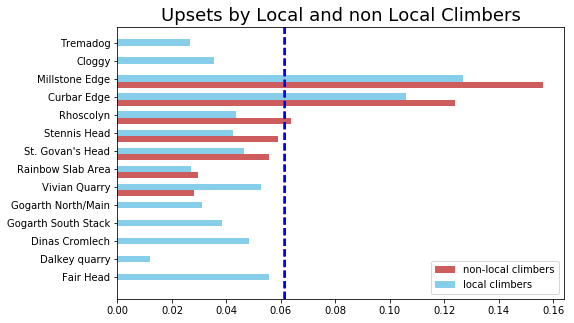

In [39]:
local_climbers = ascents[ascents.location == ascents.local_to].groupby('location')['upset'].mean()\
.reindex(crags).sort_values()

not_local_climbers = ascents[ascents.location != ascents.local_to].groupby('location')['upset'].mean()\
.reindex(local_climbers.index)

a = not_local_climbers
b = local_climbers

plt.figure(figsize = (8,5))
plt.title('Upsets by Local and non Local Climbers', fontsize=18)

ind = np.array([x for x, _ in enumerate(crags)])
width = 0.35       
plt.barh(ind, b, width, label='non-local climbers', color = 'IndianRed')
plt.barh(ind + width, a, width, label='local climbers', color = 'SkyBlue')
plt.axvline(ascents[ascents.location != ascents.local_to].upset.mean(), color='r', linestyle='--', linewidth=2)
plt.axvline(ascents[ascents.location == ascents.local_to].upset.mean(), color='b', linestyle='--', linewidth=2)
plt.yticks(ind + width*2 / 2, crags)
plt.legend(loc='best')
plt.show()

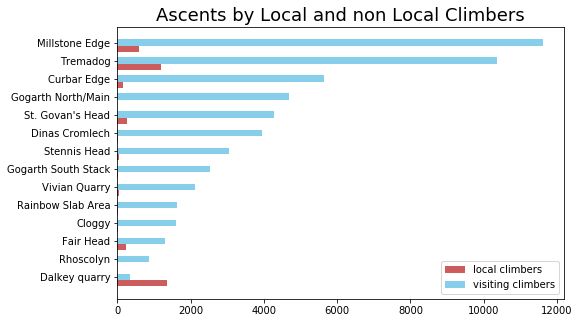

In [85]:
crags = ascents.location.unique()

not_local_climbers = ascents[ascents.location != ascents.local_to].location.value_counts()\
.reindex(crags).sort_values()

local_climbers = ascents[ascents.location == ascents.local_to].location.value_counts()\
.reindex(not_local_climbers.index)

a = local_climbers
b = not_local_climbers

plt.figure(figsize = (8,5))
plt.title('Ascents by Local and non Local Climbers', fontsize=18)

ind = np.array([x for x, _ in enumerate(crags)])
width = 0.35       
plt.barh(ind, a, width, label='local climbers', color = 'IndianRed')
plt.barh(ind + width, b, width, label='visiting climbers', color = 'SkyBlue')
plt.yticks(ind + width*2 / 2, not_local_climbers.index)
plt.legend(loc='lower right')
plt.show()

Based on the above analysis of ascents by climbers who are not local, we can see that degree to which local and non local climbers contribute to the rate of upsets at a given location varies considerably. As a result I'd like to produce a third score for the rate of upsets on a route, where upset by non-local climbers are weighted more strongly than by local climbers. 

**My main motivations**

I believe that, for the majority of cases a climbers max_grade is likely informed by the area that they are local to. 
Further, climbers local to an area are more likely to have prior-knowledge of the routes there. A climbers grading is likely to be calibrated to their local area. 

In [40]:
def weigh_upset_with_locality(upset_weight, local_to, location) :
    if upset_weight > 0: 
        if local_to == location:
            return upset_weight
        else :
            return upset_weight * 1.5
    
    return 0

In [41]:
ascents['upset_weighted_by_locality'] = ascents.apply(lambda row: weigh_upset_with_locality(\
                                                         row['upset_weight'],
                                                         row['local_to'],
                                                         row['location'],
                                                        ), axis = 1)
ascents[ascents.upset == 1].sample(5)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,upset_weight,upset_weighted_by_locality
3282,Cobweb Crack,"21 May, 2014",AltLd dnf,"lead pitch 1, neither of us could tackle pitch...",177964,VS,Dinas Cromlech,Neist,HS,HVS,1,2,3.0
22211,Tactician,"14 Jun, 2015",Lead dnf,luke cleaned it upwith luke glaister,138857,HVS,St. Govan's Head,Symonds Yat,VS,E2,1,3,4.5
43611,Regent Street,"16 Aug, 2010",Lead dog,dogged the life out of this almost didnt make ...,89635,E2,Millstone Edge,Dumbarton Rock,HVS,E5,1,4,6.0
35461,Lyons Corner House,"21 Apr, 2014",Lead dnf,"Epic, how is this 3 stars the rock is awful.wi...",113952,HVS,Millstone Edge,Stanage Popular,MVS,E3,1,4,6.0
31257,The Toy,"2 Sep, 2012",Lead dog,pumped out my mind placing gearwith JRae,33527,E1,Curbar Edge,Horseshoe Quarry,VS,E2,1,2,3.0


In [42]:
routes = pd.DataFrame(ascents.groupby(['name','grade'])['upset'].mean())
routes['upset_weighted'] = ascents.groupby(['name','grade'])['upset_weight'].mean()
routes['upset_weighted_by_locality'] = ascents.groupby(['name','grade'])['upset_weighted_by_locality'].mean()
routes['upset_z_score'], routes['weighted_z_score'] = stats.zscore(routes.upset), stats.zscore(routes.upset_weighted)
routes['locality_z_score'] = stats.zscore(routes.upset_weighted_by_locality)
routes.sample(5)

,,upset,upset_weighted,upset_weighted_by_locality,upset_z_score,weighted_z_score,locality_z_score
name,grade,,,,,,
Smarter Than The Average Bear,VS,0.019231,0.057692,0.086538,-0.546850,-0.518983,-0.506181
Blanco,HVS,0.006667,0.006667,0.010000,-0.689902,-0.708575,-0.700935
Finger Distance,E3,0.000000,0.000000,0.000000,-0.765807,-0.733346,-0.726380
Scroach,E2,0.111111,0.222222,0.333333,0.499281,0.092348,0.121794
The Concrete Chimney,HVS,0.000000,0.000000,0.000000,-0.765807,-0.733346,-0.726380


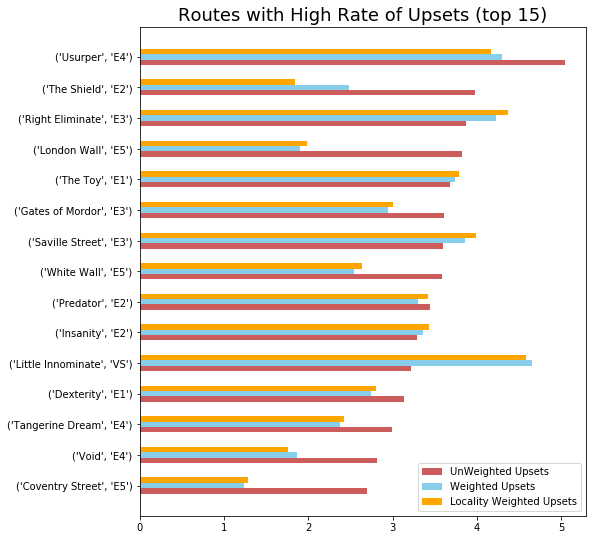

In [43]:
top_sandbags = routes.upset_z_score.sort_values().index[-15:]
a = routes.weighted_z_score.reindex(top_sandbags)
b = routes.upset_z_score.reindex(top_sandbags)
c = routes.locality_z_score.reindex(top_sandbags)

plt.figure(figsize = (8,9))
plt.title('Routes with High Rate of Upsets (top 15)', fontsize = 18)

ind = np.array([x for x, _ in enumerate(top_sandbags)])
width = 0.35       
plt.barh(ind*2, b, width, label='UnWeighted Upsets', color = 'IndianRed')
plt.barh(ind*2 + width, a, width, label='Weighted Upsets', color = 'SkyBlue')
plt.barh(ind*2 + width*2 , c, width, label= 'Locality Weighted Upsets', color= 'orange')

plt.yticks(ind*2 + width*3 / 3, top_sandbags)
plt.legend(loc='best')
plt.show()

We can see from the plot above, that the routes with the highest rate of upsets show little difference between their weighted scores and their locality weighted scores. We see below that the mean rate of upsets for local and non local ascents are the same. 

In [44]:
print('Mean for local ascents',ascents[ascents.local_to != ascents.location].upset.mean(),
     '\nMean for non local ascents',ascents[ascents.local_to == ascents.location].upset.mean())

Mean for local ascents 0.06115975365437412 
Mean for non local ascents 0.06150283067421513


## Encoding the Grade of the Route? 

Further, it appears that for many routes, the difference between the weighted and unweighted z-scores may simply indicate the grade of the route. For example, routes like 'Void' -E4 and 'Coventry Street' -E5 have weigthed z-scores far below their unweighted z-scores, while the converse is true for 'Little Innominate' -VS. We can examine this for all grades below. 

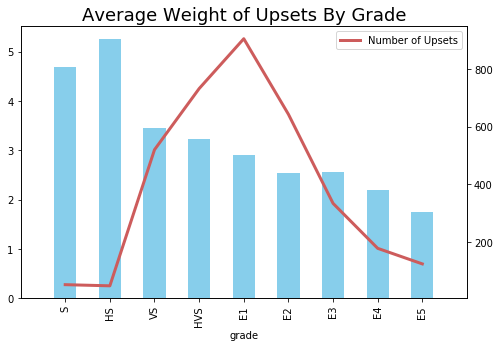

In [45]:
grades_index = ["S", "HS", "VS", "HVS", "E1", "E2", "E3", "E4", "E5"]
upsets_by_grade = pd.DataFrame(ascents.groupby('grade').upset.sum())
upsets_by_grade['upset_weighted'] = ascents.groupby('grade').upset_weight.sum()
upsets_by_grade['avg'] = upsets_by_grade.upset_weighted/upsets_by_grade.upset

plt.figure(figsize = (8,5))
plt.title('Average Weight of Upsets By Grade', fontsize=18)
ax1 = upsets_by_grade['avg'].reindex(grades_index).plot.bar(color = 'SkyBlue', linewidth = 3, label = 'Average Upset Weight')
ax2 = ax1.twinx()
ax2 = upsets_by_grade['upset'].reindex(grades_index).plot(color = 'IndianRed', linewidth = 3, label = 'Number of Upsets')
plt.legend(loc='best')
plt.xlim([-1,9])
plt.show()

It appears that there exists an inverse relationship between the grade of a route and the average weight of an upset on that route. From the plot below we see the distribution of max grades for our climbers. 

The distribution is skewed with fewer and fewer climbers in the higher grades. This leaves less potential for big upsets in these grades. It should also be noted that the grade of a routes also encodes the relative danger of the route. As a result failing at the higher grades can be less common as starting out on these routes is often a serious undertaking and not to be taken lightly. 

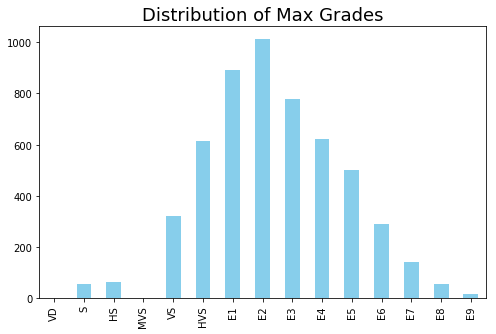

In [46]:
plt.figure(figsize = (8,5))
plt.title('Distribution of Max Grades', fontsize = 18)

# instantiate a temporary subset of the ascents dataframe, grades are replaced with int values. 
# we require the max grade for each climber, each climber is associated which a different max grade for each year.
# we want to associate each climber with their highest max grade. 

ax = pd.DataFrame([ascents.climber_id,ascents.max_grade.map(lambda grade : british_grades_dict[grade])]).T\
.groupby('climber_id').max_grade.max().value_counts().reindex(range(15)).plot.bar(color = 'SkyBlue')
grade_labels = ['VD', 'S', 'HS', 'MVS', 'VS', 'HVS', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']
ax.set_xticklabels(grade_labels)
plt.show()

The above distribution of max grades is for our sample of climbers. This sample is not representative as it only considers ascents on routes with the grade *Severe* (S) or higher. Further, for each climber we have calculated the highest max grade of any year for which we have data.

## Labeling Sandbags. 

On considering the above analysis of the different methods of measuring upsets, the rate of upsets appears to be simplest and most effective measure of a '*sandbag*'. Using a z-score of 1.25 we can label all of the routes that we consider to be *sandbags*.

In [47]:
routes = routes.reset_index(level = 'grade')
sandbags_list = routes[routes.upset_z_score >= 1.25].index

In [48]:
len(sandbags_list.tolist())

43

In [49]:
ascents['sandbag'] = ascents.apply(lambda row: 1 if str(row['name']) in sandbags_list else 0, axis = 1)
ascents.sample(5)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,upset_weight,upset_weighted_by_locality,sandbag
13889,The Strand,"15 Apr, 2012",Lead O/S,NaN,28030,E2,Gogarth North/Main,Stanage Popular,HVS,E3,0,0,0.0,0
11158,A Dream of White Horses,"18 Mar, 2014",AltLd O/S,NaN,130844,HVS,Gogarth North/Main,"Polldubh Crags, Glen Nevis",VS,E2,0,0,0.0,0
45574,Silhouette,"??, 1990",Lead O/S,NaN,127211,E2,Cloggy,Pen Trwyn,E2,E6,0,0,0.0,0
23387,Highland Fling,"27 Aug, 2009",Lead O/S,NaN,14152,HS,Stennis Head,Brimham Rocks,MVS,E1,0,0,0.0,0
44462,Hells Bells,"13 Apr, 2014",Lead O/S,NaN,88645,HS,Millstone Edge,Roaches Skyline,S,E2,0,0,0.0,0


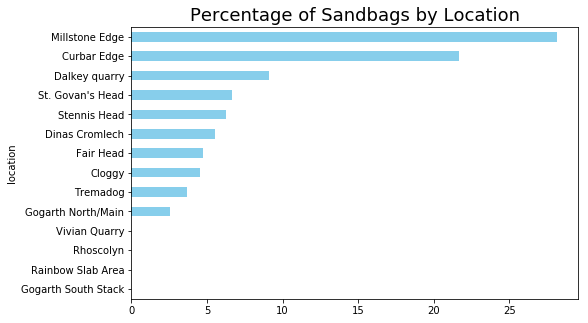

In [60]:
plt.figure(figsize = (8,5))
plt.title('Percentage of Sandbags by Location', fontsize=18)

crags = (pd.DataFrame(ascents.groupby(['name','location'])['sandbag'].mean())\
.reset_index('location').groupby('location').sandbag.mean().sort_values() * 100)
crags.plot.barh(color = 'SkyBlue')

plt.show()

## Rock - Types 

We can colour the crags by rock type. These rock types are not included in our dataset but the information is available on UKC

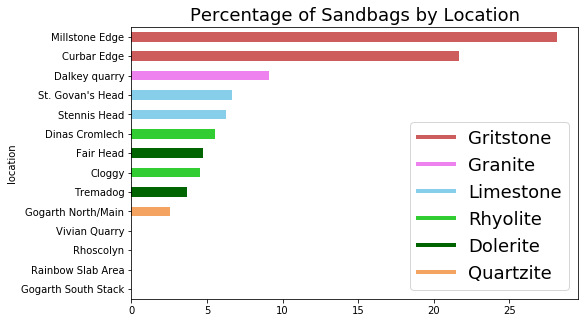

In [64]:
plt.figure(figsize = (8,5))
plt.title('Percentage of Sandbags by Location', fontsize=18)

(pd.DataFrame(ascents.groupby(['name','location'])['sandbag'].mean())\
.reset_index('location').groupby('location').sandbag.mean().sort_values() * 100).reindex()\
.plot.barh(color = ['slategrey','slategrey','sandybrown','sandybrown','sandybrown','darkgreen','limegreen',
                    'darkgreen','limegreen','skyblue','skyblue','violet','indianred','indianred'])


custom_lines = [Line2D([0], [0], color='indianred', lw=4),
                Line2D([0], [0], color='violet', lw=4),
                Line2D([0], [0], color='skyblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4),
                Line2D([0], [0], color='darkgreen', lw=4),
                Line2D([0], [0], color='sandybrown', lw=4)]

plt.legend(custom_lines, ['Gritstone', 'Granite', 'Limestone', 'Rhyolite', 'Dolerite', 'Quartzite'],
           loc = 'lower right', fontsize = 18)

plt.show()

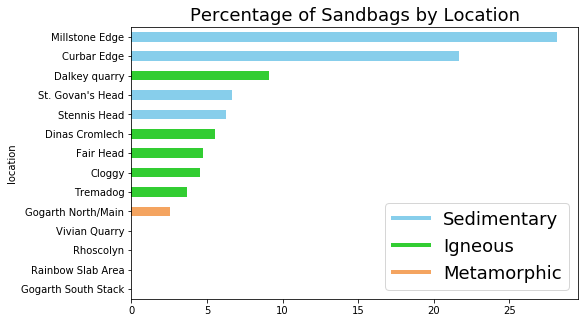

In [24]:
plt.figure(figsize = (8,5))
plt.title('Percentage of Sandbags by Location', fontsize=18)

(pd.DataFrame(ascents.groupby(['name','location'])['sandbag'].mean())\
.reset_index('location').groupby('location').sandbag.mean().sort_values() * 100).reindex()\
.plot.barh(color = ['slategrey','slategrey','sandybrown','sandybrown','sandybrown','limegreen','limegreen',
                    'limegreen','limegreen','skyblue','skyblue','limegreen','skyblue','skyblue'])


custom_lines = [Line2D([0], [0], color='skyblue', lw=4),
                Line2D([0], [0], color='limegreen', lw=4),
                Line2D([0], [0], color='sandybrown', lw=4)]

plt.legend(custom_lines, ['Sedimentary', 'Igneous', 'Metamorphic'], loc = 'lower right', fontsize=18)

plt.show()

In [25]:
ascents

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,upset_weight,upset_weighted_by_locality,sandbag
0,Hurricane,"15 Oct, 2018",Lead O/S,Another brilliant FH E2. Lead both pitches and...,57132,E2,Fair Head,Bas Cuvier,E1,E4,0,0,0.0,0
1,Hurricane,"19 Jul, 2018",Lead O/S,Led both pitch,233566,E2,Fair Head,Vivian Quarry,E1,E2,0,0,0.0,0
2,Hurricane,"7 Jul, 2018",AltLd O/S,NaN,133563,E2,Fair Head,St. Govan's Head,E2,E4,0,0,0.0,0
3,Hurricane,"25 Jun, 2018",AltLd O/S,Great splitter climbing.with Mike Hutton,12933,E2,Fair Head,Gorges du Tarn,E2,E4,0,0,0.0,0
4,Hurricane,"4 Jun, 2018",AltLd O/S,Amazing! Led p2with Aggie,158515,E2,Fair Head,Froggatt Edge,HVS,E4,0,0,0.0,0
5,Hurricane,"3 Jun, 2018",AltLd O/S,Pitch 1with bren,151893,E2,Fair Head,Dalkey quarry,E2,E7,0,0,0.0,0
6,Hurricane,"10 Jul, 2017",AltLd O/S,P2. Started up direct finish but hard so went ...,35159,E2,Fair Head,Boulder Ruckle,E2,E5,0,0,0.0,0
7,Hurricane,"10 Jul, 2017",AltLd O/S,P1 what a cracker!with Ed Babs,41303,E2,Fair Head,Winspit,E1,E5,0,0,0.0,0
8,Hurricane,"2 Jun, 2017",AltLd O/S,NaN,213309,E2,Fair Head,Dalkey quarry,E2,E5,0,0,0.0,0
9,Hurricane,"2 Jun, 2017",AltLd O/S,Lead P2. Great teamwork! ðŸ˜with Wendy Watthews,200143,E2,Fair Head,Brean Down,HVS,E5,0,0,0.0,0


In [26]:
ascents.to_csv('../data/ascents_final.csv')